In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots

# import piepline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1437) (294, 1437) (530, 1437) (803, 1437)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [4]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # ordered_transformer = Pipeline(steps=[
    #     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    #     ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(100, 1000),
            'regressor__learning_rate': space.Real(0.01, 0.05),
            'regressor__max_depth': space.Integer(2, 5),
            'regressor__subsample': space.Real(0.4, 0.8),
            'regressor__colsample_bytree': space.Real(0.4, 0.8),
            # 'regressor__min_child_weight': space.Integer(3, 5),
            # 'regressor__gamma': space.Real(0.1, 0.25),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )
    
    model.fit(X_train, y_train)
    
    return model


# GPA

In [5]:
gpa_model = run_model(train,target='gpa', classifier=False)

In [6]:
# Woodcock-Johnson Test 10 standard score
#  f3b3	0.01004	How many times have you been apart for a week or more?
#  m2c3j	0.00904	How many days a week does father put child to bed?

In [7]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4017
Standard deviation of CV scores: 0.0362
Mean CV score: 0.4147
Test MSE: 0.4234
Test R2: 0.0696
Leaderboard MSE: 0.4793
Leaderboard R2: -0.2270
Holdout MSE: 0.5210
Holdout R2: -0.2341


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


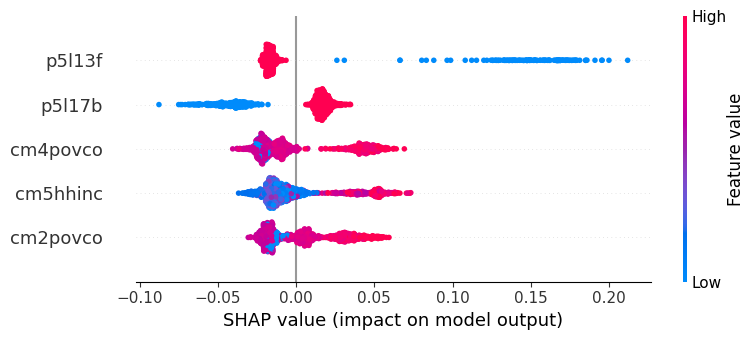

{("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm4povco',
 ("Constructed - Mother's Household income (with imputed values)",): 'cm5hhinc',
 ("L17B. Discussed academic problems with child's teacher in this/last school year",): 'p5l17b',
 ('L13F. Gifted and talented program',): 'p5l13f'}

In [8]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [9]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [10]:
model_materialHardship.best_params_

OrderedDict([('regressor__colsample_bytree', 0.41221838274599537),
             ('regressor__learning_rate', 0.021130901339300144),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 454),
             ('regressor__subsample', 0.6904807538403688)])

In [11]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.0200
Standard deviation of CV scores: 0.0022
Mean CV score: 0.0207
Test MSE: 0.0231
Test R2: 0.1525
Leaderboard MSE: 0.0348
Leaderboard R2: -0.2177
Holdout MSE: 0.0319
Holdout R2: -0.3101


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


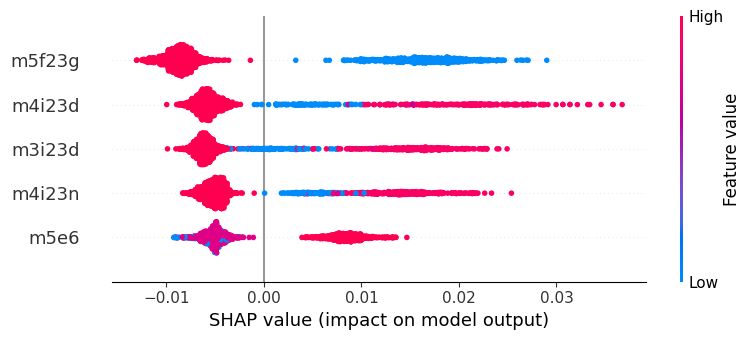

{('E6. Mother could count on someone to co-sign for a bank loan for $1000',): 'm5e6',
 ("In past year, phone service disconnected b/c wasn't enough money?",): 'm4i23n',
 ('In past year, did you not pay full gas/oil/electricity bill?',): 'm3i23d',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 ('F23G. Borrowed money from friends/family to help pay bills in past 12 months',): 'm5f23g'}

In [12]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [13]:
model_grit = run_model(train,target='grit', classifier=False)

In [14]:
# Value 2 for “(He/she) stares blankly.”
#  hv4r10a_3_1	0.01520	Value 1 for “Any hazardous condition 3: broken glass”
#  hv5_wj9raw	0.00946	Woodcock-Johnson Test 9 raw score

In [15]:
model_grit.best_params_

OrderedDict([('regressor__colsample_bytree', 0.6138721865203991),
             ('regressor__learning_rate', 0.026903038203804172),
             ('regressor__max_depth', 3),
             ('regressor__n_estimators', 282),
             ('regressor__subsample', 0.7385616673608244)])

In [16]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2391
Standard deviation of CV scores: 0.0319
Mean CV score: 0.2484
Test MSE: 0.2377
Test R2: -0.0096
Leaderboard MSE: 0.3943
Leaderboard R2: -0.7942
Holdout MSE: 0.4225
Holdout R2: -0.7684


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


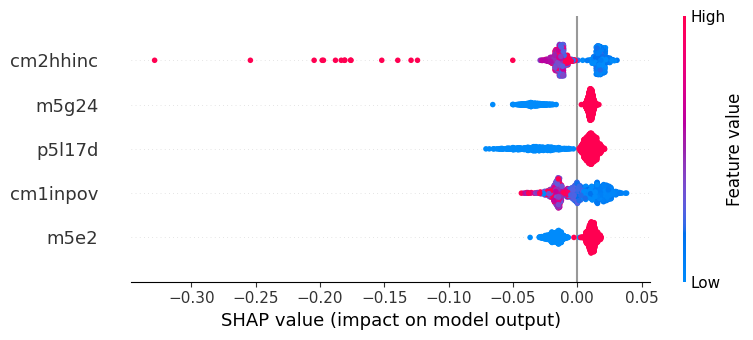

{('E2. Financial help or money from anyone other than father',): 'm5e2',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm1inpov',
 ("L17D. Discussed homework not done with child's teacher in this/last school year",): 'p5l17d',
 ('G24. Ever had a spell/attack when you felt frightened/anxious/uneasy',): 'm5g24',
 ('Constructed - Household income (with imputed values)',): 'cm2hhinc'}

In [17]:
shap_show(model_grit, alldata, target='grit')

# Eviction

In [18]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [19]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.0584
Test F1: 0.0000
Leaderboard Brier: 0.0698
Leaderboard F1: 0.0513


In [20]:
# Value “yes” for “Telephone service disconnected because wasn’t enough money in past 12 months.”
#  m5f23c_1	0.05842	Value “yes” for “Did not pay full amount of rent/mortgage payments in past 12 months.”
#  m3i4	0.02062	How much rent do you pay each month?

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


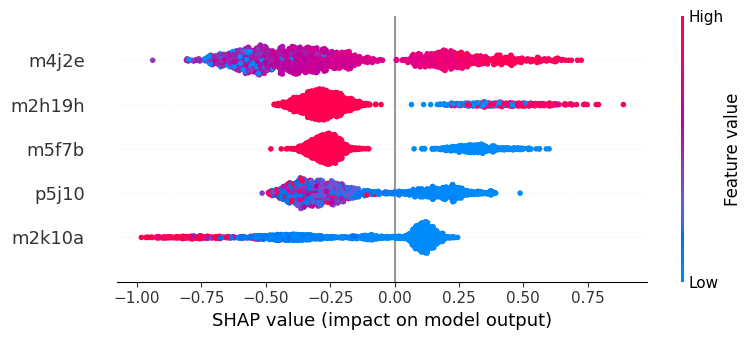

{('About how much (do/did) you usually earn in (this/that) job, before taxes?',): 'm2k10a',
 ('J10. Amount of money spent eating out in last month',): 'p5j10',
 ('F7B. Received help from a welfare office or welfare job placement in past 12 mon',): 'm5f7b',
 ('In past year, did your-Telephone service get disconnected for nonpayment?',): 'm2h19h',
 ('How much do you weigh?',): 'm4j2e'}

In [21]:
shap_show(model_eviction, alldata, target='eviction')

In [22]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [23]:
# Value “yes” for “In the last 2 years, have you taken any classes to improve your job skills?”
#  m5i1_1	0.06355	Value “yes” for “You are currently attending any school/trainings program/classes.”
#  m5i3b_1	0.06355	Value “yes” for “You have taken classes to improve job skills since last interview.”

In [24]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [25]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.2945
Test F1: 0.3065
Leaderboard Brier: 0.3340
Leaderboard F1: 0.1690


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


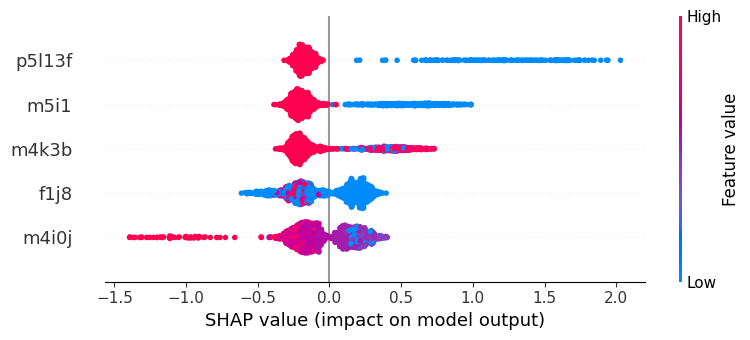

{('In general, how many close friends do you have overall?',): 'm4i0j',
 ('About how much did you earn?',): 'f1j8',
 ('In the last 2 years, have you taken any classes to improve your job skills?',): 'm4k3b',
 ('I1. You are currently attending any school/trainings program/classes',): 'm5i1',
 ('L13F. Gifted and talented program',): 'p5l13f'}

In [26]:
shap_show(model_job, alldata, target='jobTraining',n=5)

# Layoff

In [27]:
# mount of money spent eating out in last month
#  m3i0q	0.01678	How important is it to serve in the military when at war?
#  f5i13	0.01678	How much you earn in that job, before taxes

In [28]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [29]:
model_layoff.best_params_

OrderedDict([('regressor__colsample_bytree', 0.4612732096955419),
             ('regressor__learning_rate', 0.04801886001392784),
             ('regressor__max_depth', 5),
             ('regressor__n_estimators', 897),
             ('regressor__scale_pos_weight', 7),
             ('regressor__subsample', 0.5834461185125204)])

In [30]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2550
Test F1: 0.0303
Leaderboard Brier: 0.2547
Leaderboard F1: 0.1290
Holdout Brier: 0.2441


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


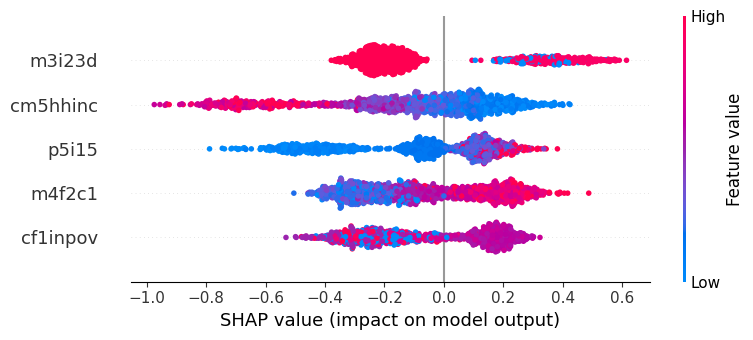

{("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cf1inpov',
 ("What is first person's age? (years)",): 'm4f2c1',
 ('I15. Number of hours TV is on',): 'p5i15',
 ("Constructed - Mother's Household income (with imputed values)",): 'cm5hhinc',
 ('In past year, did you not pay full gas/oil/electricity bill?',): 'm3i23d'}

In [31]:
shap_show(model_layoff, alldata, target='layoff')